In [1]:
import cv2 
from matplotlib import pyplot as plt

# 시작 함수

def stitching(dec, func):

    img1, img2, gray1, gray2 = loadImage('C:\\Users\\HwaJong\\Desktop\\test\\koreatech\\image1.jpg', \
                                        'C:\\Users\\HwaJong\\Desktop\\test\\koreatech\\image2.jpg')

    key1, key2, des1, des2 = findKeyPoints(gray1, gray2, dec)
    matching(img1, img2, key1, key2, des1, des2, func)

In [2]:
# 이미지 로드

def loadImage(path1, path2):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    return img1, img2, gray1, gray2

In [3]:
# detector 생성 및 특징점 추출

def findKeyPoints(img1, img2, name):

    # 추출기 생성
    if name == 'orb':
        obj = cv2.ORB_create()
    elif name == 'sift':
        obj = cv2.xfeatures2d.SIFT_create()
    elif name == 'surf':
        obj = cv2.xfeatures2d.SURF_create()
    elif name == 'kaze':
        obj = cv2.KAZE_create()
    elif name == 'brisk':
        obj = cv2.BRISK_create()
    elif name == 'akaze':
        obj = cv2.AKAZE.create()

    keypoints_1, descriptors_1 = obj.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = obj.detectAndCompute(img2,None)
    
    print('keypoints_1 :',len(keypoints_1), ' / descriptors_1:', descriptors_1.shape)
    print('keypoints_2 :',len(keypoints_2), ' / descriptors_2:', descriptors_2.shape)
    
    return keypoints_1, keypoints_2, descriptors_1, descriptors_2

In [4]:
# 두 개 이미지의 특징점 매칭

def matching(img1, img2, key1, key2, des1, des2, func):
    
    if func == 'match':
        #feature matching
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = matcher.match(des1,des2)
        
        # 매칭 결과를 거리기준 오름차순으로 정렬
        matches = sorted(matches, key = lambda x:x.distance)
        img3 = cv2.drawMatches(img1, key1, img2, key2, matches[:600], img2, flags=2)
        
        
    elif func == 'knn':
        matcher = cv2.BFMatcher()
        matches = matcher.knnMatch(des1, des2, 2)
        good = [[first] for first, second in matches if first.distance < 0.75 * second.distance]
        img3 = cv2.drawMatchesKnn(img1, key1, img2, key2, good, None, flags=2)

    plt.imshow(img3)
    plt.show()

In [ ]:
# detector 종류
detector = ['orb', 'sift', 'surf', 'kaze', 'akaze', 'brisk']

# match() 사용
for i in detector:
    print(i, 'match')
    stitching(i, 'match')
    
# knnMatch() 사용
for i in detector:
    print(i, 'knn')
    stitching(i, 'knn')

# 이미지 결합

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
# Read image and convert them to gray!!
def read_image(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img, img_rgb

In [3]:
left_gray, left_origin, left_rgb = read_image('C:\\Users\\HwaJong\\Desktop\\test\\stitching\\koreatech\\image1.jpg')
right_gray, right_origin, right_rgb = read_image('C:\\Users\\HwaJong\\Desktop\\test\\stitching\\koreatech\\image1.jpg')

In [4]:
def SIFT(img):
    siftDetector= cv2.xfeatures2d.SIFT_create() # limit 1000 points
    # siftDetector= cv2.xfeatures2d.SURF_create() # limit 1000 points
    # siftDetector= cv2.SIFT_create()  # depends on OpenCV version   # 이거 아님
    # siftDetector= cv2.AKAZE.create()
    # siftDetector= cv2.BRISK_create()
    # siftDetector= cv2.ORB_create()

    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(gray, kp, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

In [5]:
# Better result when using gray
# key point 와 디스크립터 추출

kp_left, des_left = SIFT(left_gray)
kp_right, des_right = SIFT(right_gray)

In [6]:
# key point 와 디스크립터 그리기
# 그린 이미지 결합하기

kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
# plt.imshow(total_kp)

In [7]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold * n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

In [ ]:
matches = matcher(kp_left, des_left, left_rgb, kp_right, des_right, right_rgb, 0.5)

In [ ]:
def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2   # 가로의 절반
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type
    
    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
     
    # 두 번째 사진에서 좌표에 offset 을 더해야 합쳐진 사진에 표시할 수 있음
    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()

In [ ]:
# 거리로 1차 필터링한 매칭점 그리기

total_img = np.concatenate((left_rgb, right_rgb), axis=1)  # 합친 이미지
plot_matches(matches, total_img) # Good mathces / 합친 이미지에 매칭점 그리기

In [ ]:
# 호모그래피는 한 평면을 다른 평면에 투영시킬 때 둘 사이의 변환관계
# 행렬식( 호모그래피 )을 구하는 함수

def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):  # pairs(매칭점) 개수만큼 
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)   # svd는 특이값 분해
    H = V[-1].reshape(3, 3)  # H는 호모그래피
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

In [12]:
# 매칭점에서 랜덤 포인트 추출
# 추출한 매칭점이 담긴 ndarray 반환

def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

In [13]:
def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])   # dot는 내적
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2
    # print(errors)
    return errors

In [14]:
def ransac(matches, threshold, iters):
    num_best_inliers = 0  # 가장 많은 수의 인라이어
    
    for i in range(iters):
        points = random_point(matches)  # point는 리스트, 리스트 안의 point도 x, y, x, y 가 있는 리스트 형태
        H = homography(points)   # 매칭점을 호모그래피 함수에 전달
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        # 더 좋은 선? 더 많은 인라이어가 있는 H 로 변경 및 인라이어들 기록
        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

inliers/matches: 18/28


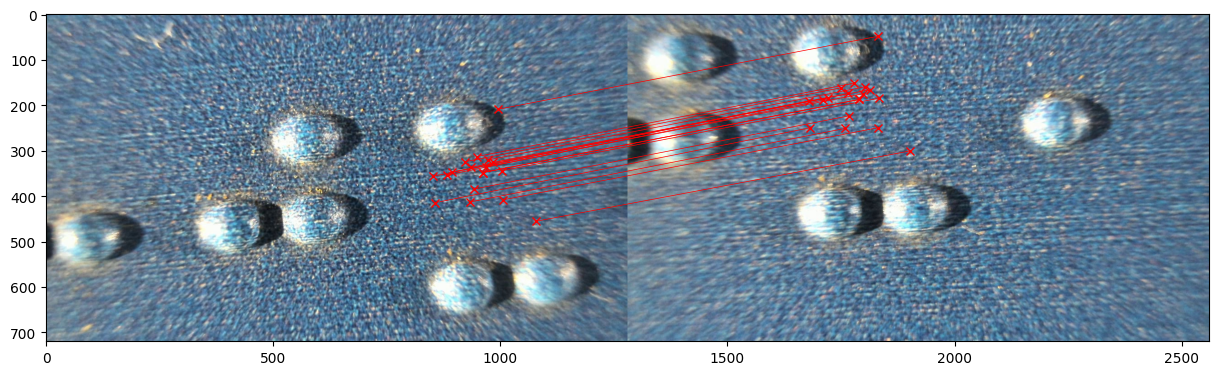

In [15]:
# RANSAC로 2차 필터링한 매칭점 그리기

inliers, H = ransac(matches, 0.5, 2000)
matches = inliers.copy()
plot_matches(inliers, total_img) # show inliers matches

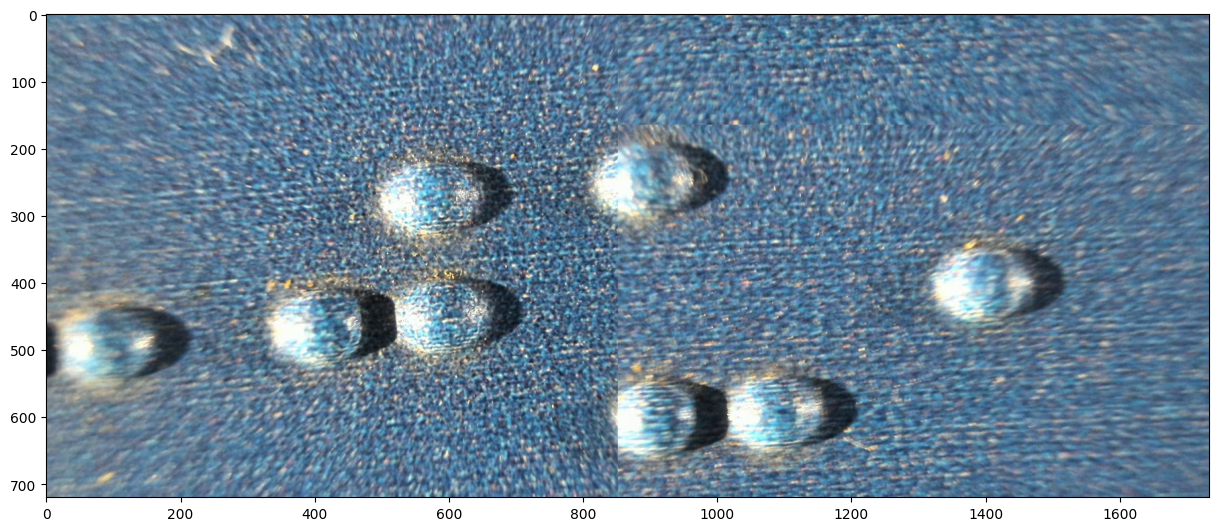

In [16]:
left = left_rgb[:, 0:int(matches[0][0])]
right = right_rgb[:, int(matches[0][2]):]

h1, w1, c1 = left.shape
h2, w2, c2 = right.shape

bg = np.full((h1, w1 + w2, 3), 0, dtype='uint8')

diff = matches[0][1] - matches[0][3]

# 오른쪽이 더 낮으면 윗부분을 자르고 아래에 붙인다
if diff < 0:
    cut = right[:abs(int(diff)), :, ]
    cut[:, :, :] = cut[0:1, 0:1]
    right = right[abs(int(diff)):, :, :]
    right = np.vstack((right, cut))

# 더 높으면 차이만큼 자르고, 위에 붙인다
elif diff > 0:
    cut = right[-abs(int(diff)):,:,]
    cut[:, :, :] = cut[0:1, 0:1]
    right = right[:-abs(int(diff)):, :, ]
    right = np.vstack((cut, right))

combine = np.hstack((left,right))
plt.imshow(combine)
plt.show()

save = cv2.cvtColor(combine, cv2.COLOR_RGB2BGR)
cv2.imwrite('C:\\Users\\HwaJong\\Desktop\\save.jpg', save)ㅐ